# Imports and Setup

Imports

In [1]:
# Importing useful libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler

import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tempfile import TemporaryDirectory
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda:0


In [3]:
#class for early stopping if validation loss is not decreasing
class earlyStop:
  def __init__(self, patience = 1, delta = 0):
    self.patience = patience #how many epochs in a row without decresing before early stoppage occurs
    self.delta = delta #buffer value so that val losses close to the minimum achieved val loss don't count against patience
    self.counter = 0
    self.lowestValLoss = float('inf')

  def checkForStop(self, valLoss): # check for early stop and update counters, return true if early stop should occur
    if (valLoss >= (self.lowestValLoss + self.delta)): #value did not decrease and was not close to the mimimum, increase counter and do early stop if counter = patience
      self.counter += 1
      if (self.counter >= self.patience):
        return True

    elif (valLoss < self.lowestValLoss): #value decreased, reset counter to 0
      self.counter = 0
      self.lowestValLoss = valLoss

    return False

Dictionary to make classification easier for humans to understand

In [4]:
lesionDict = {
    'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions ',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

# Model

Data Loading

In [5]:
# Loading dataset
batch_size = 8

data_dir = '/content/drive/MyDrive/skinLesionDataset'

df = pd.read_csv(data_dir + '/HAM10000_metadata.csv')
df['imagePath'] = df['image_id'].map(lambda x: data_dir + '/HAM10000_images/' + x + '.jpg')
df['lesionType'] = df['dx'].map(lesionDict.get)
df['lesionNumerical'] = pd.Categorical(df.lesionType).codes


In [6]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,imagePath,lesionType,lesionNumerical
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skinLesionDataset/HAM10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skinLesionDataset/HAM10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skinLesionDataset/HAM10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/skinLesionDataset/HAM10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/skinLesionDataset/HAM10...,Benign keratosis-like lesions,2


In [7]:
df.isnull().sum()

lesion_id           0
image_id            0
dx                  0
dx_type             0
age                57
sex                 0
localization        0
imagePath           0
lesionType          0
lesionNumerical     0
dtype: int64

fill in missing age values with mean

In [8]:
df['age'].fillna(df['age'].mean(), inplace=True)
df.isnull().sum()

lesion_id          0
image_id           0
dx                 0
dx_type            0
age                0
sex                0
localization       0
imagePath          0
lesionType         0
lesionNumerical    0
dtype: int64

# EDA

lesion type distribution

[Text(0, 0, '6705'),
 Text(0, 0, '1113'),
 Text(0, 0, '1099'),
 Text(0, 0, '514'),
 Text(0, 0, '327'),
 Text(0, 0, '142'),
 Text(0, 0, '115')]

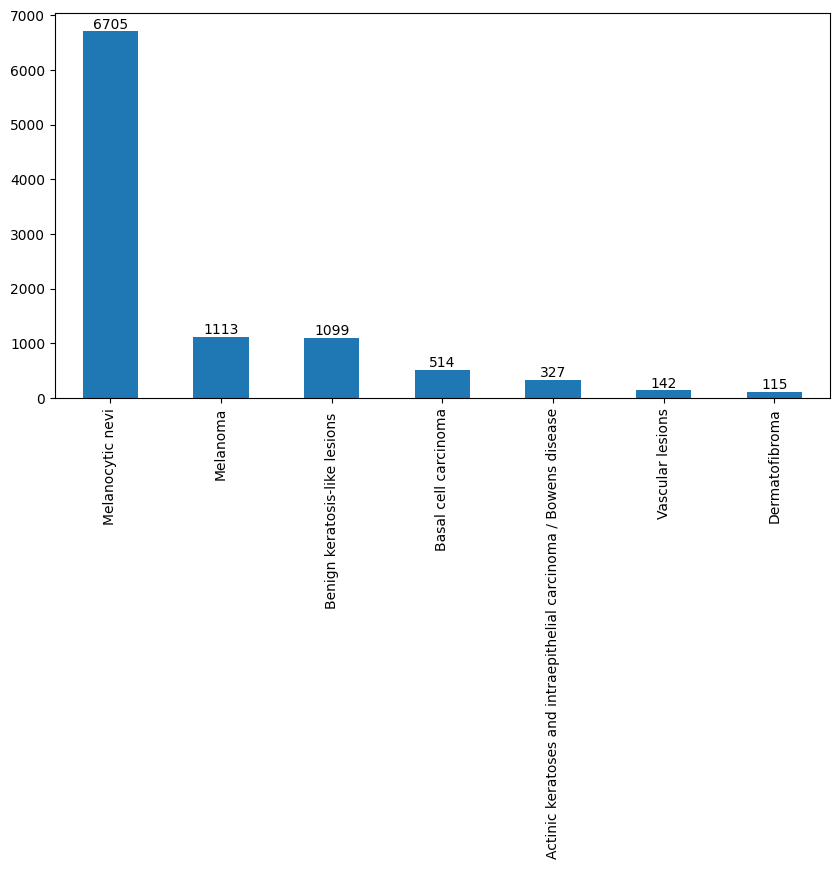

In [9]:
fig, ax = plt.subplots(1, 1, figsize= (10, 5))
df['lesionType'].value_counts().plot(kind='bar', ax = ax)
ax.bar_label(ax.containers[0])

There is a large inbalance in the data

[Text(0, 0, '5340'), Text(0, 0, '3704'), Text(0, 0, '902'), Text(0, 0, '69')]

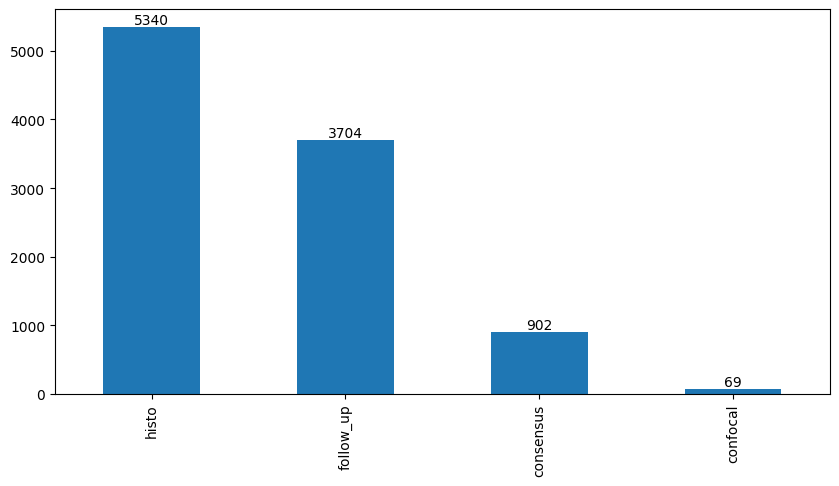

In [10]:
fig, ax = plt.subplots(1, 1, figsize= (10, 5))
df['dx_type'].value_counts().plot(kind='bar', ax = ax)
ax.bar_label(ax.containers[0])

Text(0.5, 1.0, 'Age distribution')

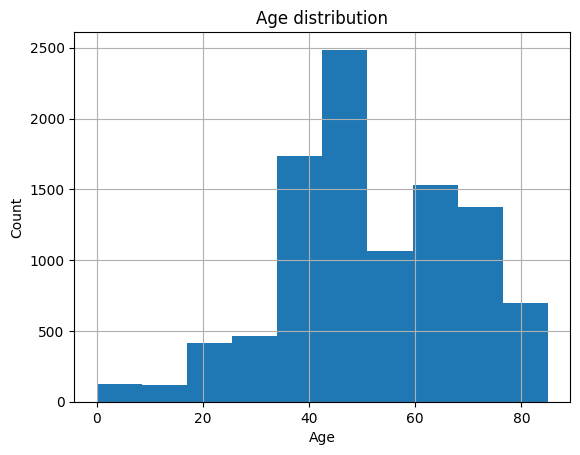

In [11]:
df['age'].hist()
plt.xlabel('Age')
plt.ylabel('Count')
plt.title("Age distribution")

[Text(0, 0, '5406'), Text(0, 0, '4552'), Text(0, 0, '57')]

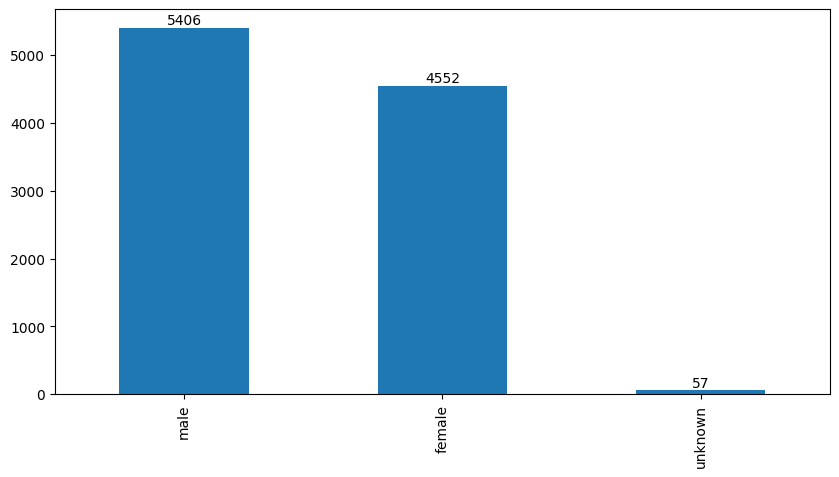

In [12]:
fig, ax = plt.subplots(1, 1, figsize= (10, 5))
df['sex'].value_counts().plot(kind='bar', ax = ax)
ax.bar_label(ax.containers[0])

[Text(0, 0, '2192'),
 Text(0, 0, '2077'),
 Text(0, 0, '1404'),
 Text(0, 0, '1118'),
 Text(0, 0, '1022'),
 Text(0, 0, '745'),
 Text(0, 0, '407'),
 Text(0, 0, '319'),
 Text(0, 0, '234'),
 Text(0, 0, '168'),
 Text(0, 0, '128'),
 Text(0, 0, '90'),
 Text(0, 0, '56'),
 Text(0, 0, '48'),
 Text(0, 0, '7')]

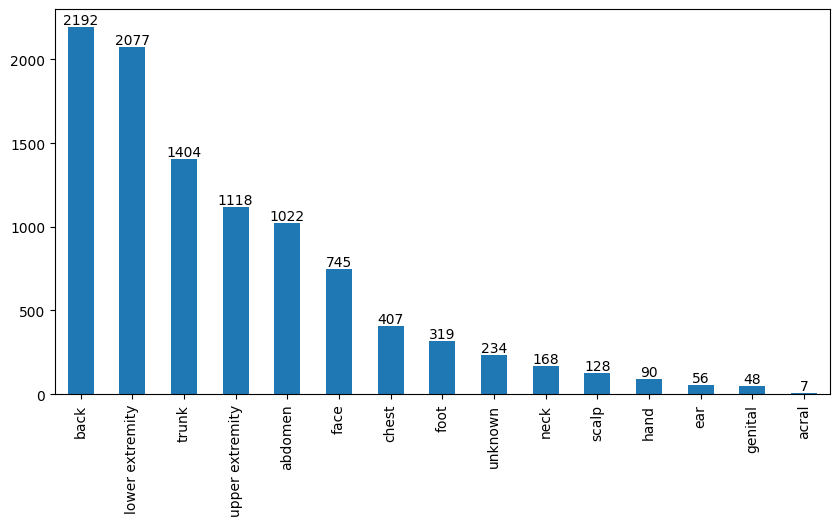

In [13]:
fig, ax = plt.subplots(1, 1, figsize= (10, 5))
df['localization'].value_counts().plot(kind='bar', ax = ax)
ax.bar_label(ax.containers[0])

# Preprocessing

Load the images into dataframe

In [14]:
#smaller df with more equal counts
#make sure all 7 acral localization rows still exist after drop
balanced_df = df.drop(df[df['lesionType'] == 'Melanocytic nevi'].sample(frac=0.80).index)
#make sure all small value localization rows still exist after drop by adding in manually
#first remove any surviving to ensure no duplicates
balanced_df = balanced_df.drop(balanced_df[balanced_df['localization'] == 'acral'].index)
balanced_df = balanced_df.append(df[df['localization'] == 'acral'])

balanced_df = balanced_df.drop(balanced_df[balanced_df['localization'] == 'genital'].index)
balanced_df = balanced_df.append(df[df['localization'] == 'genital'])

balanced_df = balanced_df.drop(balanced_df[balanced_df['localization'] == 'ear'].index)
balanced_df = balanced_df.append(df[df['localization'] == 'ear'])


balanced_df['lesionNumerical'].value_counts()

<ipython-input-14-c40503845a72>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(df[df['localization'] == 'acral'])
<ipython-input-14-c40503845a72>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(df[df['localization'] == 'genital'])
<ipython-input-14-c40503845a72>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(df[df['localization'] == 'ear'])


4    1408
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: lesionNumerical, dtype: int64

In [15]:
#one hot encode text values
balanced_df = balanced_df.join(pd.get_dummies(balanced_df['sex']))
balanced_df = balanced_df.join(pd.get_dummies(balanced_df['localization'], 'localization'))
balanced_df = balanced_df.join(pd.get_dummies(balanced_df['dx_type'], 'dx_type'))

In [16]:
X = balanced_df.drop(['lesion_id',	'image_id',	'dx',	'lesionType', 'sex', 'localization', 'dx_type'], axis =1)
X.head()

,age,imagePath,lesionNumerical,female,male,unknown,localization_abdomen,localization_acral,localization_back,localization_chest,...,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity,dx_type_confocal,dx_type_consensus,dx_type_follow_up,dx_type_histo
0,80.0,/content/drive/MyDrive/skinLesionDataset/HAM10...,2,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,80.0,/content/drive/MyDrive/skinLesionDataset/HAM10...,2,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,80.0,/content/drive/MyDrive/skinLesionDataset/HAM10...,2,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,80.0,/content/drive/MyDrive/skinLesionDataset/HAM10...,2,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6,60.0,/content/drive/MyDrive/skinLesionDataset/HAM10...,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
Y = balanced_df['lesionNumerical']
Y

0       2
1       2
2       2
3       2
6       2
       ..
9319    4
9320    4
9702    0
9921    0
9922    0
Name: lesionNumerical, Length: 4718, dtype: int8

In [18]:
x_dev, x_test, y_dev, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.20)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, stratify=y_dev, test_size=0.20)

In [19]:
x_train.shape

(3019, 25)

In [20]:
x_val.shape

(755, 25)

In [21]:
x_test.shape

(944, 25)

In [22]:
# Performing necessary preprocessing stages to resize the images according to the image size used in the pretrained model.
#Also, mean and std of images should be scaled acoording to the ImageNet dataset.
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomRotation(20, fill= 127),
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(hue = 0.05, saturation=(0.5,1.5), brightness=(0.5,1.5), contrast=(0.5, 1.5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [108]:
class lesionDataset(Dataset):
    def __init__(self, df, imageTransforms):
        self.df = df
        self.imageTransforms = imageTransforms;

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        #images
        image = Image.open(self.df['imagePath'].iloc[index])
        image = self.imageTransforms(image)

        #All the other input data must be turned into a tensor
        extraData = []

        extraData.append(self.df['age'].iloc[index])

        extraData.append(self.df['male'].iloc[index])
        extraData.append(self.df['female'].iloc[index])
        extraData.append(self.df['unknown'].iloc[index])

        extraData.append(self.df['localization_abdomen'].iloc[index])
        extraData.append(self.df['localization_acral'].iloc[index])
        extraData.append(self.df['localization_back'].iloc[index])
        extraData.append(self.df['localization_chest'].iloc[index])
        extraData.append(self.df['localization_lower extremity'].iloc[index])
        extraData.append(self.df['localization_neck'].iloc[index])
        extraData.append(self.df['localization_scalp'].iloc[index])
        extraData.append(self.df['localization_trunk'].iloc[index])
        extraData.append(self.df['localization_upper extremity'].iloc[index])
        extraData.append(self.df['localization_face'].iloc[index])
        extraData.append(self.df['localization_foot'].iloc[index])
        extraData.append(self.df['localization_hand'].iloc[index])
        extraData.append(self.df['localization_ear'].iloc[index])
        extraData.append(self.df['localization_genital'].iloc[index])
        extraData.append(self.df['localization_unknown'].iloc[index])

        extraData.append(self.df['dx_type_confocal'].iloc[index])
        extraData.append(self.df['dx_type_consensus'].iloc[index])
        extraData.append(self.df['dx_type_follow_up'].iloc[index])
        extraData.append(self.df['dx_type_histo'].iloc[index])

        #convert extra data to tensor
        extraDataTensor = torch.tensor(extraData)
        extraDataTensor = extraDataTensor.float()

        #the true labels for the sample
        label = self.df['lesionNumerical'].iloc[index]

        return image, extraDataTensor, label

In [125]:
#create data loaders for train/val/test
batchSize = 16

#datasets
train_dataset = lesionDataset(x_train, data_transforms['Train'])
val_dataset = lesionDataset(x_val, data_transforms['Validation'])
test_dataset = lesionDataset(x_test, data_transforms['Validation'])

#samplers
train_sampler = RandomSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)
test_sampler = SequentialSampler(test_dataset)

#dataloaders
train_dataloader = DataLoader(train_dataset, sampler = train_sampler, batch_size=batchSize, drop_last=True)
val_dataloader = DataLoader(val_dataset, sampler = val_sampler, batch_size=batchSize, drop_last=True)
test_dataloader = DataLoader(test_dataset, sampler = test_sampler, batch_size=batchSize, drop_last=True)

# Create the model

#Starting with training an image only model, will add in the extra data later as a multistep model incorporating this one

showing some of the images

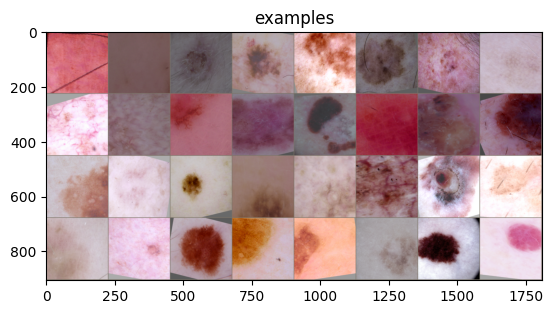

In [25]:
# Visualizing some train images
def imshow(img, title=None):
    img = img.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images, _, labels = next(iter(train_dataloader))
outputs = torchvision.utils.make_grid(images)

imshow(outputs, title='examples')

In [26]:
# Defining our model train/validation function
def image_model(model, criterion, optimizer, LR_scheduler, num_epochs):

    # creating a temporary directory to save our model
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0

        earlyStopper = earlyStop(5, 0.01)
        shouldStop = False

        # The main training loop
        for epoch in range(num_epochs):
            if shouldStop == True:
              break

            print(f'\n\nEpoch {epoch} / {num_epochs - 1}')
            print('_' * 10)


            # Each epoch has training and validation phase
            for phase in ['Train', 'Validation']:
                if phase == 'Train':
                    model.train()
                    dataloader = train_dataloader
                else:
                    model.eval()
                    datalaoder = val_dataloader

                running_loss = 0
                running_corrects = 0

                for images, _, labels in dataloader:
                    labels = labels.cuda().long()
                    images, labels = images.to(device), labels.to(device) # to send batches to the GPU

                    optimizer.zero_grad() # Everytime we set the optimizer zero to avoid residuals from previous iteration

                    with torch.set_grad_enabled(phase=='Train'): # Updating parameters in the training phase
                        outputs = model(images) # sending one batch of images to the model to get probability values
                        _,preds = torch.max(outputs, 1) # finding the label with the highest probability value
                        loss = criterion(outputs, labels) # calculating the loss

                        if phase == 'Train':
                            loss.backward() # with the loss value, we do the gradient descent in the backpropagation
                            optimizer.step() # Updating the weights of the model

                    running_loss += loss.item() * images.size(0)
                    running_corrects += torch.sum(preds==labels.data)

                if phase == 'Train':
                    LR_scheduler.step()


                epoch_loss = running_loss / len(dataloader.dataset)
                epoch_acc = running_corrects.double() / len(dataloader.dataset)
                print(f'{phase}: Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                #check for early stop
                if(phase == 'Validation'):
                  if (earlyStopper.checkForStop(epoch_loss)):
                    shouldStop = True
                    print("\n--------------------\n-----------\n Stopping Early as Validation Error is no longer decreasing\n\n")
                    break

                if phase == 'Validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path) # saving the best model


        print(f'Best validation accuracy: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    return model


In [27]:
# The model that we choose is ConvNeXtBase due to its highes accuracy for our problem.
model = models.convnext_base(weights='IMAGENET1K_V1')
for param in model.parameters(): # we freeze the parameters as we do not want to compute gradients for those parameters
    param.requires_grad = False

model.classifier[2] = torch.nn.Linear(in_features=model.classifier[2].in_features, out_features=7)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

LR_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
trained_image_model = image_model(model, criterion, optimizer, LR_scheduler, num_epochs=30)



Epoch 0 / 29
__________
Train: Loss: 1.4407 Acc: 0.4349
Validation: Loss: 1.2495 Acc: 0.5161


Epoch 1 / 29
__________
Train: Loss: 1.2341 Acc: 0.5194
Validation: Loss: 1.1624 Acc: 0.5455


Epoch 2 / 29
__________
Train: Loss: 1.1672 Acc: 0.5581
Validation: Loss: 1.1024 Acc: 0.5876


Epoch 3 / 29
__________
Train: Loss: 1.1284 Acc: 0.5701
Validation: Loss: 1.0659 Acc: 0.5936


Epoch 4 / 29
__________
Train: Loss: 1.0875 Acc: 0.5853
Validation: Loss: 1.0535 Acc: 0.5966


Epoch 5 / 29
__________
Train: Loss: 1.0810 Acc: 0.5992
Validation: Loss: 1.0385 Acc: 0.5966


Epoch 6 / 29
__________
Train: Loss: 1.0592 Acc: 0.6052
Validation: Loss: 0.9967 Acc: 0.6187


Epoch 7 / 29
__________
Train: Loss: 1.0284 Acc: 0.6055
Validation: Loss: 0.9951 Acc: 0.6161


Epoch 8 / 29
__________
Train: Loss: 1.0265 Acc: 0.6081
Validation: Loss: 0.9925 Acc: 0.6197


Epoch 9 / 29
__________
Train: Loss: 1.0357 Acc: 0.6088
Validation: Loss: 0.9980 Acc: 0.6168


Epoch 10 / 29
__________
Train: Loss: 1.0350 Acc

In [29]:
correct = 0
total = 0
y_pred = []
y_true = []

# We do not calculate the gradients as we are not in the training phase
with torch.no_grad():
    for data in test_dataloader:
        images,  _, labels = data
        images = images.to(device)
        labels = labels.cuda().long()
        labels = labels.to(device)

        y_true.extend(labels.data.cpu().numpy())

        outputs = trained_image_model(images) # Sending one batch to the model to calculate the output (prabability value)

        _, predicted = torch.max(outputs.data, 1) # Finding the label with the highiest probability value
        y_pred.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total} %')

# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)

class_names = ['Actinic keratoses and intraepithelial carcinoma / Bowens disease',
    'Basal cell carcinoma',
    'Benign keratosis-like lesions ',
    'Dermatofibroma',
    'Melanoma',
    'Melanocytic nevi',
    'Vascular lesions']

# Accuracy per class
Acc_class = cm.diagonal()/cm.sum(axis=1)
Acc_per_class = {}
j = 0
for i in class_names:
    Acc_per_class[i] = Acc_class[j]
    j += 1
print("Accuracy per class:", Acc_per_class)

# Creating pandas dataframe
dataframe = pd.DataFrame(cm, index=class_names, columns=class_names)
dataframe

Accuracy of the model on the test images: 64.30084745762711 %
Accuracy per class: {'Actinic keratoses and intraepithelial carcinoma / Bowens disease': 0.3384615384615385, 'Basal cell carcinoma': 0.5728155339805825, 'Benign keratosis-like lesions ': 0.5727272727272728, 'Dermatofibroma': 0.08695652173913043, 'Melanoma': 0.8297872340425532, 'Melanocytic nevi': 0.6412556053811659, 'Vascular lesions': 0.75}


,Actinic keratoses and intraepithelial carcinoma / Bowens disease,Basal cell carcinoma,Benign keratosis-like lesions,Dermatofibroma,Melanoma,Melanocytic nevi,Vascular lesions
Actinic keratoses and intraepithelial carcinoma / Bowens disease,22,13,15,0,3,12,0
Basal cell carcinoma,1,59,23,0,8,11,1
Benign keratosis-like lesions,4,11,126,1,17,61,0
Dermatofibroma,0,1,3,2,11,6,0
Melanoma,1,4,9,0,234,34,0
Melanocytic nevi,2,5,30,0,42,143,1
Vascular lesions,0,1,0,0,5,1,21


#multi-input model

In [127]:
class lesionModel(nn.Module):
  def __init__(self, imageModel):
    super(lesionModel, self).__init__()
    #individual image model
    self.imageModel = imageModel

    self.fc = nn.Linear(30,30)

    self.fcExtra = nn.Linear(23,23)

    # dropout layer
    self.dropout = nn.Dropout(0.1)

    # relu activation function
    self.relu =  nn.ReLU()

    #compress down to 7 outputs
    self.classifier = nn.Linear(30, 7)


  def forward(self, imageInput, extraData):
    #run inputs through individual models
    imageOutput = self.imageModel(imageInput)

    #concatentate the non image inputs and run classification
    combinedInput = torch.cat((imageOutput, extraData), dim=1)

    #layer
    combinedOutput = self.fc(combinedInput)

    #Relu + dropout
    combinedOutput = self.relu(combinedOutput)
    combinedOutput = self.dropout(combinedOutput)

    #layer
    combinedOutput = self.fc(combinedOutput)

    #compress to 7 outputs
    combinedOutput = self.classifier(combinedOutput)

    #output
    return combinedOutput


In [128]:
#Training function
def fullTrain(model, dataloader, optimizer, criterion):
  print('Training...')
  model.train()

  runningLoss, runningAccuracy = 0, 0

  runningPreds = []

  #iterates over the batches in the dataloader
  for step, batch in enumerate(dataloader):

    #inputs + labels = batch
    imageInputs, extraData, labels = batch

    #push to gpu
    labels = labels.cuda().long()

    imageInputs = images.to(device)
    extraData = extraData.to(device)
    labels = labels.to(device)

    #set the gradients to zero to avoid residuals from previous iteration
    model.zero_grad()

    #get predictions from model
    preds = model(imageInputs, extraData)

    #calculate loss
    loss = criterion(preds, labels)
    runningLoss += loss.item()
    #back propogation
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    #update the model parameters
    optimizer.step()

    #move preds from gpu to cpu
    preds = preds.detach().cpu().numpy()
    runningPreds.append(preds)

  averageLoss = runningLoss / len(dataloader)

  runnningPreds = np.concatenate(runningPreds, axis = 0)

  return averageLoss, runningPreds

In [129]:
#Validation Function
def fullValidate(model, dataloader, criterion):
  print('Validating...')
  model.eval()

  runningLoss, runningAccuracy = 0, 0

  runningPreds = []

  #iterates over the batches in the dataloader
  for step, batch in enumerate(dataloader):

    #inputs + labels = batch
    imageInputs, extraData, labels = batch

    #push to gpu
    labels = labels.cuda().long()

    imageInputs = images.to(device)
    extraData = extraData.to(device)
    labels = labels.to(device)

    #don't compute gradients during validation
    with torch.no_grad():

      #get predictions from model
      preds = model(imageInputs, extraData)

      #calculate loss
      loss = criterion(preds, labels)
      runningLoss += loss.item()

      #move preds from gpu to cpu
      preds = preds.detach().cpu().numpy()
      runningPreds.append(preds)

  averageLoss = runningLoss / len(dataloader)

  runnningPreds = np.concatenate(runningPreds, axis = 0)

  return averageLoss, runningPreds

Setup model

In [130]:
#freeze all layers in sub models
for param in trained_image_model.parameters():
  param.requires_grad = False

In [131]:
#set up model / loss function/ optimizers

#pass in pretrained models
full_model = lesionModel(trained_image_model)
full_model = full_model.to(device) #push to GPU or CPU

#optmizer (gradient descent)
combined_optimizer = optim.Adam(full_model.parameters(), lr=0.001)

#loss function
combined_criterion = nn.CrossEntropyLoss()

#number of epochs for training
combined_epochs = 100

In [132]:
#training the model!
bestValidationLoss = float('inf')
bestRunTrainingLoss = float('inf')

trainLosses = []
validationLosses = []

earlyStopper = earlyStop(5, 0.01)

#loop through epochs
for epoch in range(combined_epochs):

  print( "\nEpoch: " + str(epoch + 1) + "\n ---------------------------------------------\n")

  #train
  trainLoss, _ = fullTrain(full_model, train_dataloader, combined_optimizer, combined_criterion)

  #validate
  valLoss, _ = fullValidate(full_model, val_dataloader, combined_criterion)

  if(earlyStopper.checkForStop(valLoss)):
    print("\n--------------------\n-----------\n Stopping Early as Validation Error is no longer decreasing")
    break

  #save best model (based on validation loss)
  if valLoss < bestValidationLoss:
    bestValidationLoss = valLoss
    bestRunTrainingLoss = trainLoss
    torch.save(full_model.state_dict(), 'saved_weights.pt')

  trainLosses.append(trainLoss)
  validationLosses.append(valLoss)

  print("Training Loss: " + str(trainLoss))
  print("Validation Loss: " + str(valLoss))


print("Training loss from best run: " + str(bestRunTrainingLoss))
print("Best Validation Loss: " + str(bestValidationLoss))



Epoch: 1
 ---------------------------------------------

Training...
Validating...
Training Loss: 1.7671585958054725
Validation Loss: 1.6292580366134644

Epoch: 2
 ---------------------------------------------

Training...
Validating...
Training Loss: 1.6427512910771878
Validation Loss: 1.5719337108287406

Epoch: 3
 ---------------------------------------------

Training...
Validating...
Training Loss: 1.5735578213600403
Validation Loss: 1.530581570686178

Epoch: 4
 ---------------------------------------------

Training...
Validating...
Training Loss: 1.5093673052305872
Validation Loss: 1.4922768765307488

Epoch: 5
 ---------------------------------------------

Training...
Validating...
Training Loss: 1.4563440880242815
Validation Loss: 1.4178454647672938

Epoch: 6
 ---------------------------------------------

Training...
Validating...
Training Loss: 1.401164136985515
Validation Loss: 1.3538553537206446

Epoch: 7
 ---------------------------------------------

Training...
Validati

In [137]:
#finally we get to run preds on the test set
correct = 0
total = 0
y_pred = []
y_true = []

#load saved weights of best model
full_model.load_state_dict(torch.load('saved_weights.pt'))

#run preds
with torch.no_grad():
  for data in test_dataloader:
    imageInputs, extraData, labels = data

    y_true.extend(labels.data.cpu().numpy())

    labels = labels.cuda().long()

    imageInputs = images.to(device)
    extraData = extraData.to(device)
    labels = labels.to(device)

    outputs = full_model(imageInputs, extraData) # Sending one batch to the model to calculate the output (prabability value)

    _, predicted = torch.max(outputs.data, 1) # Finding the label with the highiest probability value
    y_pred.extend(predicted.cpu().numpy())

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total} %')

# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Accuracy per class
Acc_class = cm.diagonal()/cm.sum(axis=1)
Acc_per_class = {}
j = 0
for i in class_names:
    Acc_per_class[i] = Acc_class[j]
    j += 1
print("Accuracy per class:", Acc_per_class)

# Creating pandas dataframe
dataframe = pd.DataFrame(cm, index=class_names, columns=class_names)


Accuracy of the model on the test images: 51.69491525423729 %
Accuracy per class: {'Actinic keratoses and intraepithelial carcinoma / Bowens disease': 0.0, 'Basal cell carcinoma': 0.0, 'Benign keratosis-like lesions ': 0.4954545454545455, 'Dermatofibroma': 0.5652173913043478, 'Melanoma': 0.7127659574468085, 'Melanocytic nevi': 0.726457399103139, 'Vascular lesions': 0.10714285714285714}
